Classify existance or non-existance of people in images of the linked dataset with deep learning.

In [ ]:
import os
user = "nabiyevnabi" 
key = "a71dd9dc0d5a513a8ec433eaf4708f2d"
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d bulentsiyah/semantic-drone-dataset


100% 3.83G/3.83G [00:47<00:00, 52.2MB/s]



In [ ]:
!unzip semantic-drone-dataset.zip

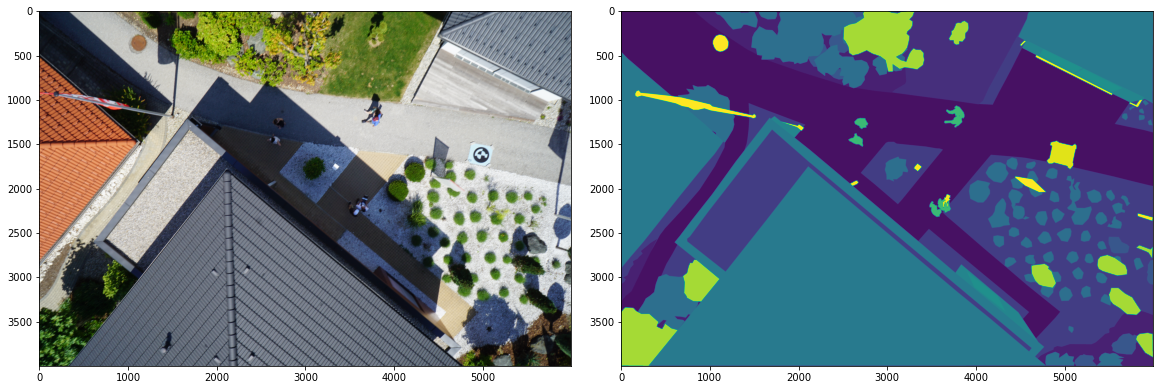

In [ ]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from skimage import io
original_image = "/content/semantic_drone_dataset/original_images/005.jpg"
label_image_semantic = "/content/semantic_drone_dataset/label_images_semantic/005.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))
axs[0].grid(False)

label_image_semantic = Image.open(label_image_semantic)
label_image_semantic = np.asarray(label_image_semantic)
axs[1].imshow(label_image_semantic)
axs[1].grid(False)

The distributor of this dataset has said that photo is segmented into 23 classes.

We need only to segment pixels of images into 2 classes:person and non-person.Values,that are equal to 15 in semantic images,refer to persons

In [ ]:
indexes=list(np.where(label_image_semantic==15))

By creating new array,I would set the "person" pixels into 1,and other pixels to 0,to transform 23-classified emantical image into 2-classified(NOTE THAT original was containing values from 0 to 22,the new image contains values 0 and 1)

In [ ]:
new_label_image_semantic=np.zeros((4000,6000))
for i in range(len(indexes[0])):
  y_axis=indexes[0][i]
  x_axis=indexes[1][i]
  new_label_image_semantic[y_axis,x_axis]=1

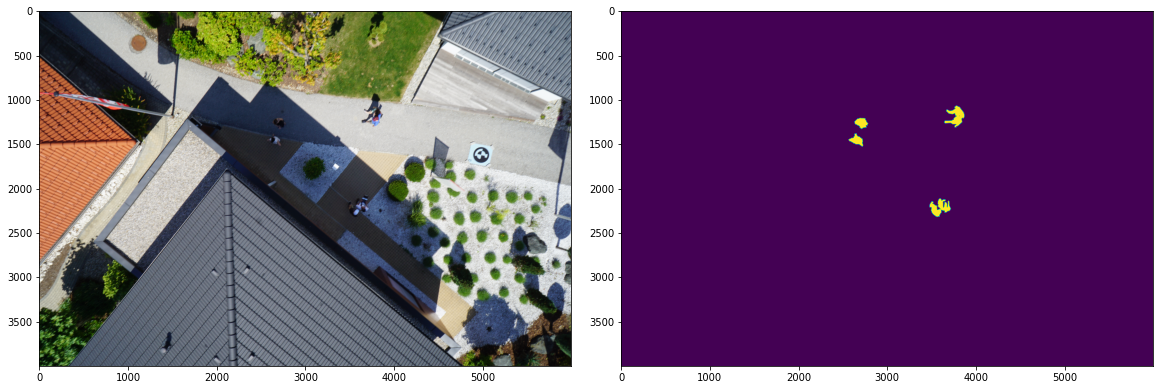

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
axs[0].imshow( Image.open(original_image))
axs[0].grid(False)
axs[1].imshow(new_label_image_semantic)
axs[1].grid(False)

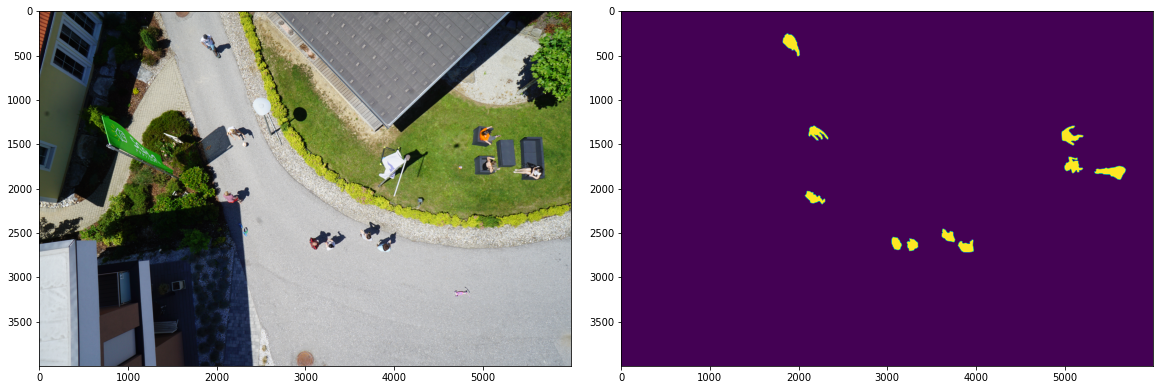

In [ ]:
original_image = "/content/semantic_drone_dataset/original_images/049.jpg"
label_image_semantic = "/content/semantic_drone_dataset/label_images_semantic/049.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))
axs[0].grid(False)

label_image_semantic = Image.open(label_image_semantic)
label_image_semantic = np.asarray(label_image_semantic)
indexes=list(np.where(label_image_semantic==15))

new_label_image_semantic=np.zeros((4000,6000))
for i in range(len(indexes[0])):
  y_axis=indexes[0][i]
  x_axis=indexes[1][i]
  new_label_image_semantic[y_axis,x_axis]=1
axs[1].imshow(new_label_image_semantic)
axs[1].grid(False)

In [ ]:
def segment_only_people(label_image_semantic):
  label_image_semantic = Image.open(label_image_semantic)
  label_image_semantic = np.asarray(label_image_semantic)
  indexes=list(np.where(label_image_semantic==15))

  new_label_image_semantic=np.zeros((4000,6000))
  for i in range(len(indexes[0])):
    y_axis=indexes[0][i]
    x_axis=indexes[1][i]
    new_label_image_semantic[y_axis,x_axis]=1
  return new_label_image_semantic  

In [ ]:
os.mkdir("semantic_drone_dataset/new_label_images_semantic")

In [ ]:
for dn in sorted(os.listdir("semantic_drone_dataset/label_images_semantic/")):
  new_label_image_semantic=segment_only_people("semantic_drone_dataset/label_images_semantic/"+dn)
  new_label_image_semantic=new_label_image_semantic.astype(np.uint8)
  img = Image.fromarray(new_label_image_semantic,mode='L')
  img.save("semantic_drone_dataset/new_label_images_semantic/"+dn)

I will use special model for image segmentation,which is VGG-UNET

In [ ]:
!pip install keras-segmentation

In [ ]:
from keras_segmentation.models.unet import vgg_unet

n_classes = 2
model = vgg_unet(n_classes=n_classes ,input_height=416, input_width=608)

model.train( 
    train_images =  "semantic_drone_dataset/original_images/",
    train_annotations = "semantic_drone_dataset/new_label_images_semantic/",
    checkpoints_path = "vgg_unet" , epochs=10,steps_per_epoch=10
)

  0%|          | 0/400 [00:00<?, ?it/s]

Verifying training dataset


100%|██████████| 400/400 [04:05<00:00,  1.63it/s]


Dataset verified! 
Epoch 1/10
10/10 [==============================] - 211s 21s/step - loss: 1.0627 - accuracy: 0.4743
Epoch 2/10
10/10 [==============================] - 210s 21s/step - loss: 1.0473 - accuracy: 0.4719
Epoch 3/10
10/10 [==============================] - 210s 21s/step - loss: 1.0354 - accuracy: 0.4782
Epoch 4/10
10/10 [==============================] - 214s 21s/step - loss: 1.0481 - accuracy: 0.4737
Epoch 5/10
10/10 [==============================] - 210s 21s/step - loss: 1.0386 - accuracy: 0.4804
Epoch 6/10
10/10 [==============================] - 211s 21s/step - loss: 1.0121 - accuracy: 0.4683
Epoch 7/10
10/10 [==============================] - 213s 21s/step - loss: 1.0061 - accuracy: 0.4554
Epoch 8/10
10/10 [==============================] - 210s 21s/step - loss: 1.0077 - accuracy: 0.4688
Epoch 9/10
10/10 [==============================] - 211s 21s/step - loss: 1.0126 - accuracy: 0.4678
Epoch 10/10
10/10 [==============================] - 210s 21s/step - loss: 0.9957

I didnt have any other choice but to take 10 samples for each epoch.The training process is long,and,therefore,using 200 samples each epoch is undesirable.Accuracy was not so good,because I used little data.

Let's see the predictions of our model!

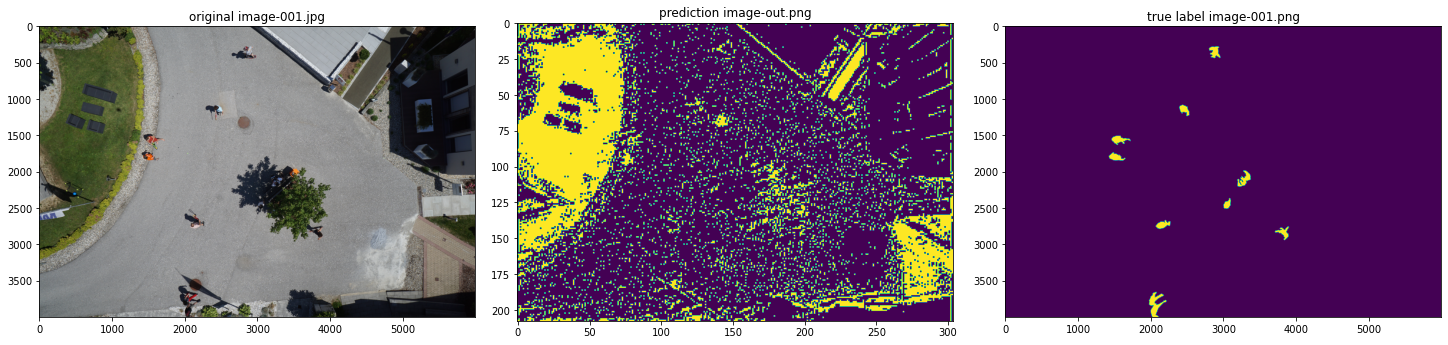

In [ ]:
input_image = "semantic_drone_dataset/original_images/002.jpg"
out = model.predict_segmentation(
    inp=input_image,
    out_fname="out.png"
)

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open(input_image)
axs[0].imshow(img_orig)
axs[0].set_title('original image-001.jpg')
axs[0].grid(False)

axs[1].imshow(out)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = "semantic_drone_dataset/new_label_images_semantic/002.png"
axs[2].imshow( Image.open(validation_image))
axs[2].set_title('true label image-001.png')
axs[2].grid(False)


Here,we see lots of small green points and medium yellow blots.That medium yellow blots are people,and we can even see the location of some of the people.Actually,these locations don't matter,because our task is to classify if there is any human or not.

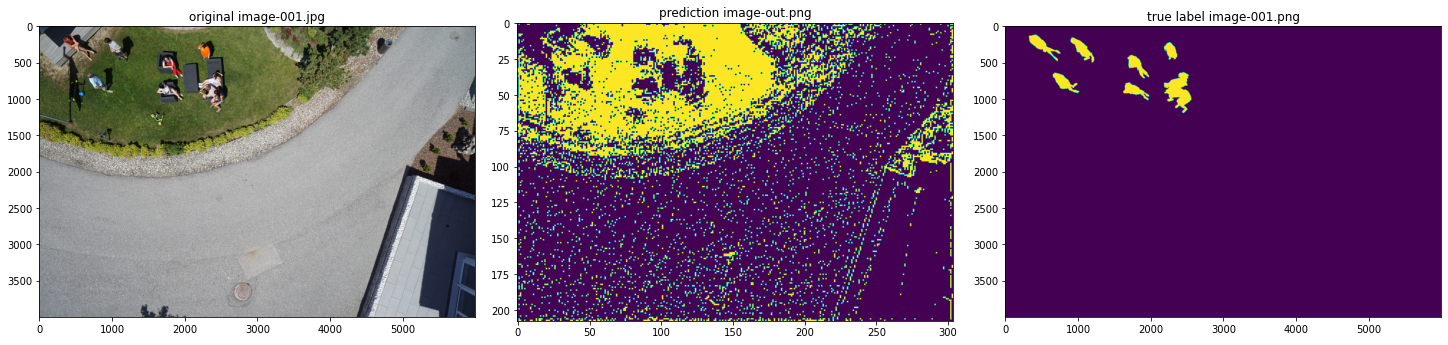

In [ ]:
input_image = "semantic_drone_dataset/original_images/107.jpg"
out = model.predict_segmentation(
    inp=input_image,
    out_fname="out.png"
)

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open(input_image)
axs[0].imshow(img_orig)
axs[0].set_title('original image-001.jpg')
axs[0].grid(False)

axs[1].imshow(out)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = "semantic_drone_dataset/new_label_images_semantic/107.png"
axs[2].imshow( Image.open(validation_image))
axs[2].set_title('true label image-001.png')
axs[2].grid(False)


The big black blots in yellow cluster are humans

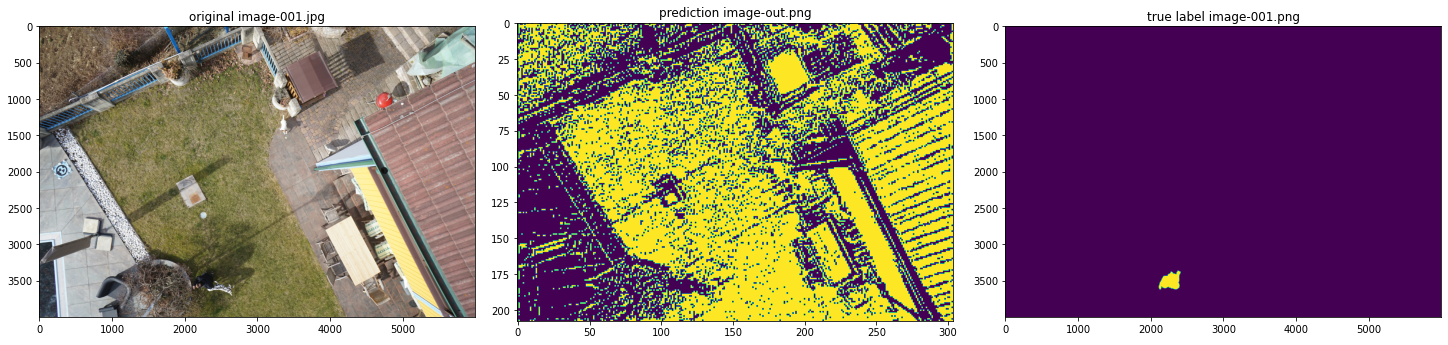

In [ ]:
input_image = "semantic_drone_dataset/original_images/113.jpg"
out = model.predict_segmentation(
    inp=input_image,
    out_fname="out.png"
)

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open(input_image)
axs[0].imshow(img_orig)
axs[0].set_title('original image-001.jpg')
axs[0].grid(False)

axs[1].imshow(out)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = "semantic_drone_dataset/new_label_images_semantic/113.png"
axs[2].imshow( Image.open(validation_image))
axs[2].set_title('true label image-001.png')
axs[2].grid(False)


Here we dont see any sharp blots and density of colors are ditributed equally.Actually we missed one person,but sometimes model can miss people,who are located in hard places(in this case,near the tree)

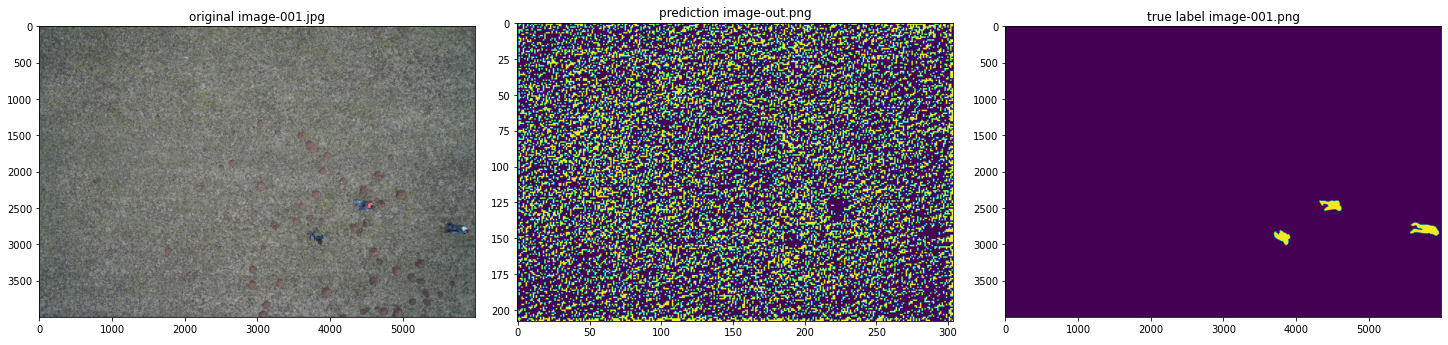

In [ ]:
input_image = "semantic_drone_dataset/original_images/146.jpg"
out = model.predict_segmentation(
    inp=input_image,
    out_fname="out.png"
)

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open(input_image)
axs[0].imshow(img_orig)
axs[0].set_title('original image-001.jpg')
axs[0].grid(False)

axs[1].imshow(out)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = "semantic_drone_dataset/new_label_images_semantic/146.png"
axs[2].imshow( Image.open(validation_image))
axs[2].set_title('true label image-001.png')
axs[2].grid(False)

***So,to wrap up,when in color spaces(doesn't matter if the space is green,black or yellow) we see any sharp blot in considerable eye-catching size,then it's most probably a location of human***